# Circuit Complexity & Success Probability — Paper Figure Recreation

Recreates the combined complexity and success probability figure from the OneBQF paper.
Uses pre-computed data from `OneBQF/data/` (circuit depth, gate counts, success rates).

**Panels:**
- (a) IBM Torino hardware compilation — two-qubit gate count vs matrix size
- (b) TKET Full Peephole Optimization — two-qubit gate count vs matrix size
- (c) Success probability scaling with residuals

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from collections import defaultdict
from pathlib import Path
import os

## Helper Classes

In [2]:
def group_measurements(data):
    """Group success probability measurements by problem size."""
    grouped = defaultdict(list)
    for m in data:
        key = (m['problem_size']['n_particles'],
               m['problem_size']['layers'],
               m['problem_size']['matrix_size'])
        grouped[key].append(m['measurement_stats']['success_rate'])

    result = {'n_particles': [], 'layers': [], 'N': [], 'M': [],
              'P_succ_mean': [], 'P_succ_std': [], 'P_succ_sem': []}
    for (n_p, layers, N), P_values in sorted(grouped.items()):
        result['n_particles'].append(n_p)
        result['layers'].append(layers)
        result['N'].append(N)
        result['M'].append(n_p * (layers - 1))
        result['P_succ_mean'].append(np.mean(P_values))
        result['P_succ_std'].append(np.std(P_values, ddof=1))
        result['P_succ_sem'].append(np.std(P_values, ddof=1) / np.sqrt(len(P_values)))
    return {k: np.array(v) for k, v in result.items()}


class GateCountFit:
    """Gate count fit: G = a * N^b * log(N) + d"""
    def __init__(self):
        self.c_fixed = 1.0

    def model(self, N, a, b, d):
        return a * np.power(N, b) * np.power(np.log(N), self.c_fixed) + d

    def fit(self, N, gates):
        popt, pcov = curve_fit(self.model, N, gates, p0=[1.0, 0.5, 0.0], maxfev=50000)
        return popt, pcov

    def confidence_band(self, N, popt, pcov):
        a, b, d = popt
        y_fit = self.model(N, a, b, d)
        J = np.array([
            np.power(N, b) * np.log(N),
            a * np.power(N, b) * np.log(N)**2,
            np.ones_like(N)
        ]).T
        y_var = np.sum((J @ pcov) * J, axis=1)
        margin = 1.96 * np.sqrt(np.abs(y_var))
        return y_fit, y_fit - margin, y_fit + margin


class SuccessProbabilityFit:
    """Success probability fit: P_succ = a * N^b"""
    def __init__(self, layers):
        self.layers = layers

    def model(self, N, a, b):
        return a * np.power(N, b)

    def fit(self, N, M, P_succ, P_succ_err):
        weights = 1.0 / (P_succ_err**2 + 1e-10)
        sigma = 1.0 / np.sqrt(weights)
        a_init = P_succ[0] * np.sqrt(N[0])
        popt, pcov = curve_fit(self.model, N, P_succ, p0=[a_init, -0.5],
                               sigma=sigma, absolute_sigma=True, maxfev=50000)
        a, b = popt
        return a, b, np.sqrt(pcov[0, 0]), np.sqrt(pcov[1, 1]), pcov

    def confidence_band(self, N, a, b, pcov):
        P_fit = self.model(N, a, b)
        J = np.array([np.power(N, b), a * np.power(N, b) * np.log(N)]).T
        P_var = np.sum((J @ pcov) * J, axis=1)
        margin = 1.96 * np.sqrt(np.abs(P_var))
        return P_fit, P_fit - margin, P_fit + margin

    def extract_c_filter(self, a, b, a_err, b_err, N_ref):
        sqrt_l = np.sqrt(self.layers - 1)
        c_filter = 2 * a * np.power(N_ref, b + 0.5) / sqrt_l
        dc_da = 2 * np.power(N_ref, b + 0.5) / sqrt_l
        dc_db = 2 * a * np.power(N_ref, b + 0.5) * np.log(N_ref) / sqrt_l
        c_filter_err = np.sqrt(dc_da**2 * a_err**2 + dc_db**2 * b_err**2)
        return c_filter, c_filter_err

    def calculate_r2(self, N, P_succ, a, b):
        P_pred = self.model(N, a, b)
        return 1 - np.sum((P_succ - P_pred)**2) / np.sum((P_succ - np.mean(P_succ))**2)

    def calculate_chi2_dof(self, N, P_succ, P_succ_err, a, b):
        P_pred = self.model(N, a, b)
        chi2 = np.sum(((P_succ - P_pred) / P_succ_err)**2)
        dof = len(N) - 2
        return chi2 / dof if dof > 0 else np.nan, dof


def calc_r2(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

## Load Data

In [3]:
# Path to OneBQF data
DATA_DIR = Path(r'C:\Users\GeorgeWilliam\Documents\GitHub\OneBQF\data')

# --- Gate Count Data ---
with open(DATA_DIR / 'circuit_depth.json', 'r') as f:
    metrics_general = json.load(f)

data_3L = [m for m in metrics_general if m['problem_size']['layers'] == 3]
data_5L = [m for m in metrics_general if m['problem_size']['layers'] == 5]

ms_3L = np.array([m['problem_size']['matrix_size'] for m in data_3L])
np_3L = [m['problem_size']['n_particles'] for m in data_3L]
tq_qiskit_3L = np.array([m['standard']['hardware_torino']['two_qubit_gates'] for m in data_3L])
tq_tket_3L = np.array([m['standard']['tket']['two_qubit_gates'] for m in data_3L])

ms_5L = np.array([m['problem_size']['matrix_size'] for m in data_5L])
np_5L = [m['problem_size']['n_particles'] for m in data_5L]
tq_qiskit_5L = np.array([m['standard']['hardware_torino']['two_qubit_gates'] for m in data_5L])
tq_tket_5L = np.array([m['standard']['tket']['two_qubit_gates'] for m in data_5L])

# --- Success Probability Data ---
with open(DATA_DIR / 'success_counts.json', 'r') as f:
    measurement_data = json.load(f)

prob_3L = group_measurements([m for m in measurement_data if m['problem_size']['layers'] == 3])
prob_5L = group_measurements([m for m in measurement_data if m['problem_size']['layers'] == 5])

print(f"Gate count data: {len(data_3L)} entries (3L), {len(data_5L)} entries (5L)")
print(f"Success prob data: {len(prob_3L['N'])} sizes (3L), {len(prob_5L['N'])} sizes (5L)")

Gate count data: 8 entries (3L), 7 entries (5L)
Success prob data: 10 sizes (3L), 10 sizes (5L)


## Perform Fits

In [4]:
# ---- Gate Count Fits ----
fit_g = GateCountFit()
popt_q3, pcov_q3 = fit_g.fit(ms_3L, tq_qiskit_3L)
popt_q5, pcov_q5 = fit_g.fit(ms_5L, tq_qiskit_5L)
popt_t3, pcov_t3 = fit_g.fit(ms_3L, tq_tket_3L)
popt_t5, pcov_t5 = fit_g.fit(ms_5L, tq_tket_5L)

r2_q3 = calc_r2(tq_qiskit_3L, fit_g.model(ms_3L, *popt_q3))
r2_q5 = calc_r2(tq_qiskit_5L, fit_g.model(ms_5L, *popt_q5))
r2_t3 = calc_r2(tq_tket_3L, fit_g.model(ms_3L, *popt_t3))
r2_t5 = calc_r2(tq_tket_5L, fit_g.model(ms_5L, *popt_t5))

print("Gate Count Fits  G = a*N^b*log(N) + d")
print(f"  Qiskit 3L: R²={r2_q3:.6f}, b={popt_q3[1]:.3f}±{np.sqrt(pcov_q3[1,1]):.3f}")
print(f"  Qiskit 5L: R²={r2_q5:.6f}, b={popt_q5[1]:.3f}±{np.sqrt(pcov_q5[1,1]):.3f}")
print(f"  TKET 3L:   R²={r2_t3:.6f}, b={popt_t3[1]:.3f}±{np.sqrt(pcov_t3[1,1]):.3f}")
print(f"  TKET 5L:   R²={r2_t5:.6f}, b={popt_t5[1]:.3f}±{np.sqrt(pcov_t5[1,1]):.3f}")

# ---- Success Probability Fits ----
fp3 = SuccessProbabilityFit(layers=3)
fp5 = SuccessProbabilityFit(layers=5)

a3, b3, ae3, be3, pcov_p3 = fp3.fit(prob_3L['N'], prob_3L['M'], prob_3L['P_succ_mean'], prob_3L['P_succ_sem'])
a5, b5, ae5, be5, pcov_p5 = fp5.fit(prob_5L['N'], prob_5L['M'], prob_5L['P_succ_mean'], prob_5L['P_succ_sem'])

N_ref_3 = np.sqrt(prob_3L['N'].min() * prob_3L['N'].max())
N_ref_5 = np.sqrt(prob_5L['N'].min() * prob_5L['N'].max())
cf3, cfe3 = fp3.extract_c_filter(a3, b3, ae3, be3, N_ref_3)
cf5, cfe5 = fp5.extract_c_filter(a5, b5, ae5, be5, N_ref_5)

r2_p3 = fp3.calculate_r2(prob_3L['N'], prob_3L['P_succ_mean'], a3, b3)
r2_p5 = fp5.calculate_r2(prob_5L['N'], prob_5L['P_succ_mean'], a5, b5)
chi2_3, dof_3 = fp3.calculate_chi2_dof(prob_3L['N'], prob_3L['P_succ_mean'], prob_3L['P_succ_sem'], a3, b3)
chi2_5, dof_5 = fp5.calculate_chi2_dof(prob_5L['N'], prob_5L['P_succ_mean'], prob_5L['P_succ_sem'], a5, b5)

# Theoretical c_filter values
lam_s3, lam_c3 = 3, 2
lam_s5, lam_c5 = 2.38196601, 1.38196601
cf_theory_3 = np.cos(np.pi * lam_s3 / (2 * lam_c3))**2
cf_theory_5 = np.cos(np.pi * lam_s5 / (2 * lam_c5))**2

print(f"\nSuccess Probability Fits  P = a * N^b")
print(f"  3L: a={a3:.6f}±{ae3:.6f}, b={b3:.4f}±{be3:.4f}")
print(f"      c_filter={cf3:.4f}±{cfe3:.4f} (theory: {cf_theory_3:.4f})")
print(f"      R²={r2_p3:.6f}, chi²/dof={chi2_3:.3f}")
print(f"  5L: a={a5:.6f}±{ae5:.6f}, b={b5:.4f}±{be5:.4f}")
print(f"      c_filter={cf5:.4f}±{cfe5:.4f} (theory: {cf_theory_5:.4f})")
print(f"      R²={r2_p5:.6f}, chi²/dof={chi2_5:.3f}")

Gate Count Fits  G = a*N^b*log(N) + d
  Qiskit 3L: R²=0.999854, b=0.528±0.008
  Qiskit 5L: R²=0.999756, b=0.577±0.013
  TKET 3L:   R²=0.999992, b=0.524±0.002
  TKET 5L:   R²=0.999991, b=0.518±0.002

Success Probability Fits  P = a * N^b
  3L: a=0.353374±0.000113, b=-0.4998±0.0001
      c_filter=0.5006±0.0005 (theory: 0.5000)
      R²=0.999977, chi²/dof=302.040
  5L: a=0.812351±0.000179, b=-0.4999±0.0001
      c_filter=0.8129±0.0005 (theory: 0.8231)
      R²=1.000000, chi²/dof=101.912


## Generate Combined Figure

Saved to Plots/


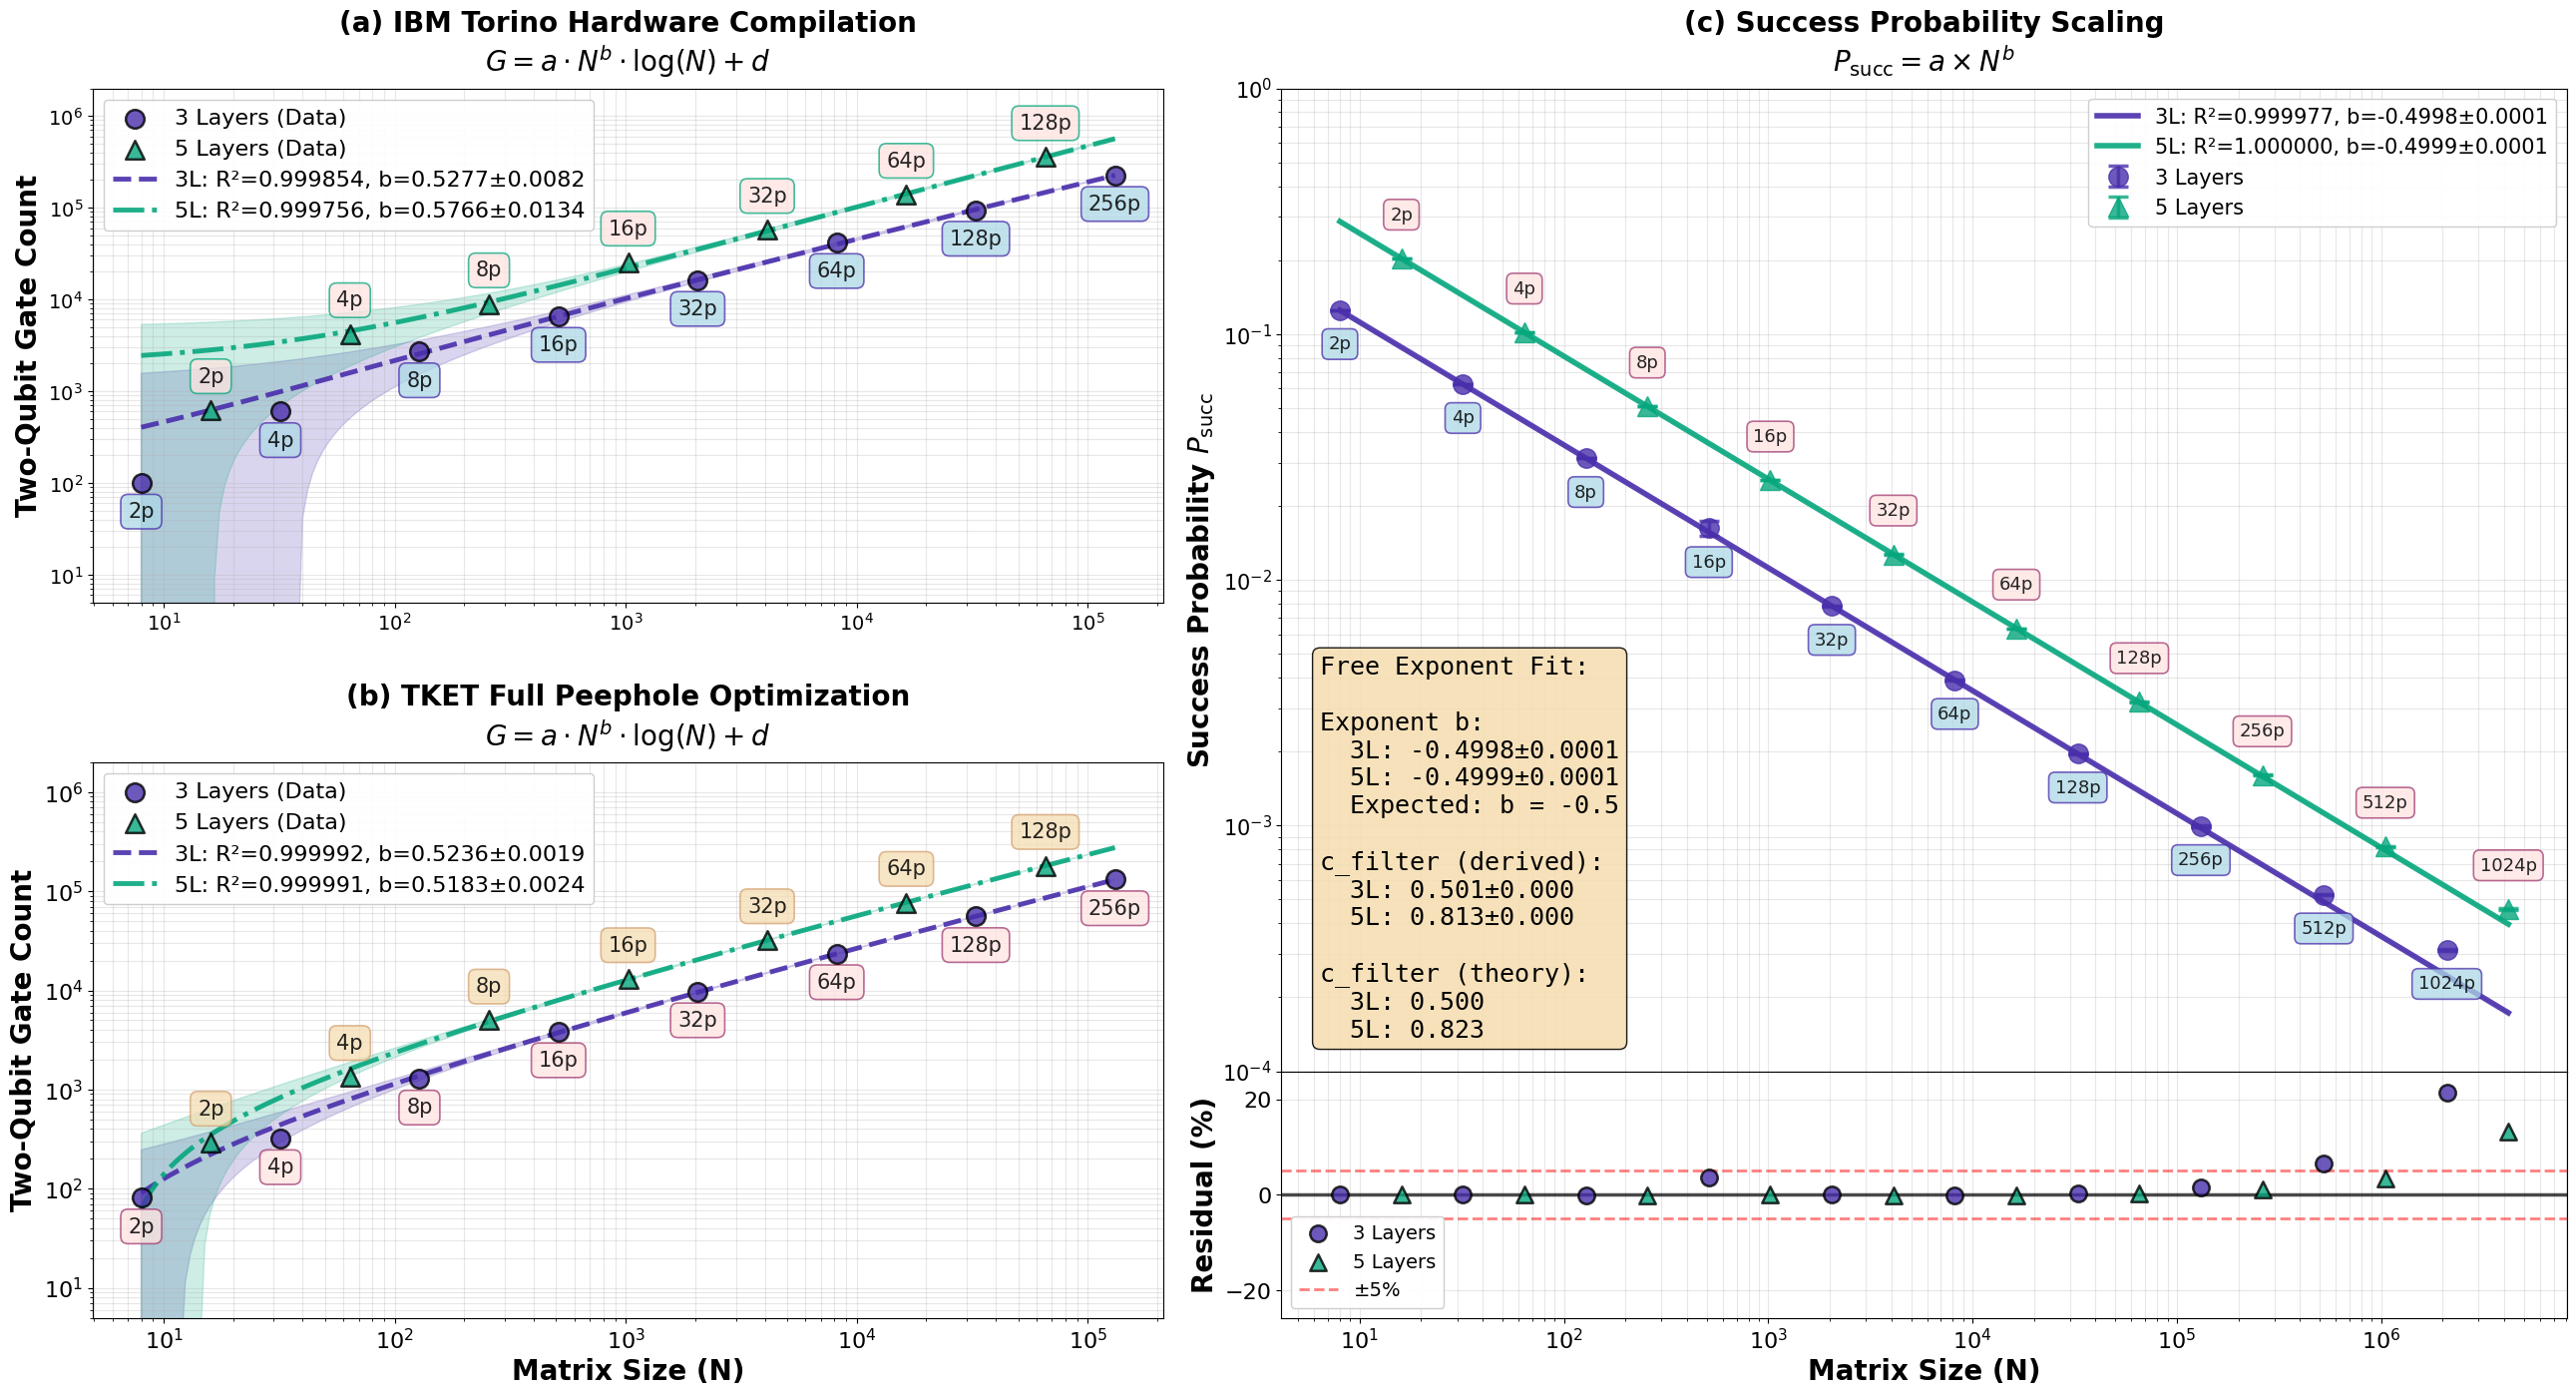

In [5]:
# Smooth curves for fits
N_smooth_g = np.logspace(np.log10(min(ms_3L.min(), ms_5L.min())),
                         np.log10(max(ms_3L.max(), ms_5L.max())), 200)
N_smooth_p = np.logspace(np.log10(min(prob_3L['N'].min(), prob_5L['N'].min())),
                         np.log10(max(prob_3L['N'].max(), prob_5L['N'].max())), 200)

# Confidence bands
fit_q3, lo_q3, hi_q3 = fit_g.confidence_band(N_smooth_g, popt_q3, pcov_q3)
fit_q5, lo_q5, hi_q5 = fit_g.confidence_band(N_smooth_g, popt_q5, pcov_q5)
fit_t3, lo_t3, hi_t3 = fit_g.confidence_band(N_smooth_g, popt_t3, pcov_t3)
fit_t5, lo_t5, hi_t5 = fit_g.confidence_band(N_smooth_g, popt_t5, pcov_t5)
fit_p3, lo_p3, hi_p3 = fp3.confidence_band(N_smooth_p, a3, b3, pcov_p3)
fit_p5, lo_p5, hi_p5 = fp5.confidence_band(N_smooth_p, a5, b5, pcov_p5)

# Residuals
pred_3 = fp3.model(prob_3L['N'], a3, b3)
pred_5 = fp5.model(prob_5L['N'], a5, b5)
res_3 = (prob_3L['P_succ_mean'] - pred_3) / prob_3L['P_succ_mean'] * 100
res_5 = (prob_5L['P_succ_mean'] - pred_5) / prob_5L['P_succ_mean'] * 100

# --- PLOT ---
C3 = '#492EAB'  # purple for 3-layer
C5 = '#06A77D'  # green for 5-layer

fig = plt.figure(figsize=(32, 16))
gs = gridspec.GridSpec(4, 2, height_ratios=[1, 0.15, 1, 0.00001],
                       width_ratios=[1.0, 1.2], hspace=0.15, wspace=0.10)
gs_right = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[:, 1],
                                            height_ratios=[4, 1], hspace=0.001)

# --- (a) Qiskit ---
ax_q = fig.add_subplot(gs[0, 0])
ax_q.scatter(ms_3L, tq_qiskit_3L, marker='o', s=180, alpha=0.8, color=C3,
             edgecolors='black', linewidth=1.8, zorder=5, label='3 Layers (Data)')
ax_q.scatter(ms_5L, tq_qiskit_5L, marker='^', s=180, alpha=0.8, color=C5,
             edgecolors='black', linewidth=1.8, zorder=5, label='5 Layers (Data)')
ax_q.plot(N_smooth_g, fit_q3, '--', lw=3.5, alpha=0.9, color=C3,
          label=f'3L: R²={r2_q3:.6f}, b={popt_q3[1]:.4f}±{np.sqrt(pcov_q3[1,1]):.4f}')
ax_q.fill_between(N_smooth_g, lo_q3, hi_q3, alpha=0.2, color=C3)
ax_q.plot(N_smooth_g, fit_q5, '-.', lw=3.5, alpha=0.9, color=C5,
          label=f'5L: R²={r2_q5:.6f}, b={popt_q5[1]:.4f}±{np.sqrt(pcov_q5[1,1]):.4f}')
ax_q.fill_between(N_smooth_g, lo_q5, hi_q5, alpha=0.2, color=C5)
for i, (ms, n) in enumerate(zip(ms_3L, np_3L)):
    ax_q.annotate(f'{n}p', (ms, tq_qiskit_3L[i]), textcoords='offset points',
                  xytext=(0, -25), ha='center', fontsize=15, alpha=0.85,
                  bbox=dict(boxstyle='round,pad=0.35', facecolor='lightblue',
                           alpha=0.75, edgecolor=C3, linewidth=1.2))
for i, (ms, n) in enumerate(zip(ms_5L, np_5L)):
    ax_q.annotate(f'{n}p', (ms, tq_qiskit_5L[i]), textcoords='offset points',
                  xytext=(0, 20), ha='center', fontsize=15, alpha=0.85,
                  bbox=dict(boxstyle='round,pad=0.35', facecolor='#FFE4E1',
                           alpha=0.75, edgecolor=C5, linewidth=1.2))
ax_q.set_ylabel('Two-Qubit Gate Count', fontsize=20, fontweight='bold')
ax_q.set_title('(a) IBM Torino Hardware Compilation\n' +
               r'$G = a \cdot N^{b} \cdot \log(N) + d$', fontsize=20, fontweight='bold', pad=12)
ax_q.legend(loc='upper left', fontsize=16, framealpha=0.95)
ax_q.grid(True, alpha=0.3, which='both')
ax_q.set_xscale('log'); ax_q.set_yscale('log')
ax_q.set_ylim(5e0, 2e6)
ax_q.tick_params(labelsize=14)

# --- (b) TKET ---
ax_t = fig.add_subplot(gs[2:4, 0])
ax_t.scatter(ms_3L, tq_tket_3L, marker='o', s=180, alpha=0.8, color=C3,
             edgecolors='black', linewidth=1.8, zorder=5, label='3 Layers (Data)')
ax_t.scatter(ms_5L, tq_tket_5L, marker='^', s=180, alpha=0.8, color=C5,
             edgecolors='black', linewidth=1.8, zorder=5, label='5 Layers (Data)')
ax_t.plot(N_smooth_g, fit_t3, '--', lw=3.5, alpha=0.9, color=C3,
          label=f'3L: R²={r2_t3:.6f}, b={popt_t3[1]:.4f}±{np.sqrt(pcov_t3[1,1]):.4f}')
ax_t.fill_between(N_smooth_g, lo_t3, hi_t3, alpha=0.2, color=C3)
ax_t.plot(N_smooth_g, fit_t5, '-.', lw=3.5, alpha=0.9, color=C5,
          label=f'5L: R²={r2_t5:.6f}, b={popt_t5[1]:.4f}±{np.sqrt(pcov_t5[1,1]):.4f}')
ax_t.fill_between(N_smooth_g, lo_t5, hi_t5, alpha=0.2, color=C5)
for i, (ms, n) in enumerate(zip(ms_3L, np_3L)):
    ax_t.annotate(f'{n}p', (ms, tq_tket_3L[i]), textcoords='offset points',
                  xytext=(0, -25), ha='center', fontsize=15, alpha=0.85,
                  bbox=dict(boxstyle='round,pad=0.35', facecolor='#FFE4E1',
                           alpha=0.75, edgecolor='#A23B72', linewidth=1.2))
for i, (ms, n) in enumerate(zip(ms_5L, np_5L)):
    ax_t.annotate(f'{n}p', (ms, tq_tket_5L[i]), textcoords='offset points',
                  xytext=(0, 20), ha='center', fontsize=15, alpha=0.85,
                  bbox=dict(boxstyle='round,pad=0.35', facecolor='wheat',
                           alpha=0.75, edgecolor='#D4A373', linewidth=1.2))
ax_t.set_xlabel('Matrix Size (N)', fontsize=20, fontweight='bold')
ax_t.set_ylabel('Two-Qubit Gate Count', fontsize=20, fontweight='bold')
ax_t.set_title('(b) TKET Full Peephole Optimization\n' +
               r'$G = a \cdot N^{b} \cdot \log(N) + d$', fontsize=20, fontweight='bold', pad=12)
ax_t.legend(loc='upper left', fontsize=16, framealpha=0.95)
ax_t.grid(True, alpha=0.3, which='both')
ax_t.set_xscale('log'); ax_t.set_yscale('log')
ax_t.set_ylim(5e0, 2e6)
ax_t.tick_params(labelsize=16)

# --- (c) Success Probability ---
ax_p = fig.add_subplot(gs_right[0])
ax_r = fig.add_subplot(gs_right[1], sharex=ax_p)

ax_p.errorbar(prob_3L['N'], prob_3L['P_succ_mean'], yerr=1.96*prob_3L['P_succ_sem'],
              fmt='o', ms=14, alpha=0.8, color=C3, ecolor=C3, capsize=7,
              capthick=2.5, elinewidth=2.5, zorder=5, label='3 Layers')
ax_p.plot(N_smooth_p, fit_p3, '-', lw=4, alpha=0.9, color=C3,
          label=f'3L: R²={r2_p3:.6f}, b={b3:.4f}±{be3:.4f}')
ax_p.fill_between(N_smooth_p, lo_p3, hi_p3, alpha=0.2, color=C3)

ax_p.errorbar(prob_5L['N'], prob_5L['P_succ_mean'], yerr=1.96*prob_5L['P_succ_sem'],
              fmt='^', ms=14, alpha=0.8, color=C5, ecolor=C5, capsize=7,
              capthick=2.5, elinewidth=2.5, zorder=5, label='5 Layers')
ax_p.plot(N_smooth_p, fit_p5, '-', lw=4, alpha=0.9, color=C5,
          label=f'5L: R²={r2_p5:.6f}, b={b5:.4f}±{be5:.4f}')
ax_p.fill_between(N_smooth_p, lo_p5, hi_p5, alpha=0.2, color=C5)

# Annotations
for i, (N, P, m) in enumerate(zip(prob_3L['N'], prob_3L['P_succ_mean'], prob_3L['n_particles'])):
    ax_p.annotate(f'{m}p', (N, P), textcoords='offset points', xytext=(0, -28),
                  ha='center', fontsize=13, alpha=0.85,
                  bbox=dict(boxstyle='round,pad=0.35', facecolor='lightblue',
                           alpha=0.75, edgecolor=C3, linewidth=1.2))
for i, (N, P, m) in enumerate(zip(prob_5L['N'], prob_5L['P_succ_mean'], prob_5L['n_particles'])):
    ax_p.annotate(f'{m}p', (N, P), textcoords='offset points', xytext=(0, 28),
                  ha='center', fontsize=13, alpha=0.85,
                  bbox=dict(boxstyle='round,pad=0.35', facecolor='#FFE4E1',
                           alpha=0.75, edgecolor='#A23B72', linewidth=1.2))

ax_p.set_ylabel(r'Success Probability $P_{\mathrm{succ}}$', fontsize=20, fontweight='bold')
ax_p.set_title('(c) Success Probability Scaling\n' +
               r'$P_{\mathrm{succ}} = a \times N^{b}$', fontsize=20, fontweight='bold', pad=12)
ax_p.legend(loc='upper right', fontsize=15, framealpha=0.95)
ax_p.grid(True, alpha=0.3, which='both')
ax_p.set_xscale('log'); ax_p.set_yscale('log')
ax_p.set_ylim(1e-4, 1)
ax_p.tick_params(labelbottom=False, labelsize=15)

# Text box
textstr = (f'Free Exponent Fit:\n\n'
           f'Exponent b:\n'
           f'  3L: {b3:.4f}±{be3:.4f}\n'
           f'  5L: {b5:.4f}±{be5:.4f}\n'
           f'  Expected: b = -0.5\n\n'
           f'c_filter (derived):\n'
           f'  3L: {cf3:.3f}±{cfe3:.3f}\n'
           f'  5L: {cf5:.3f}±{cfe5:.3f}\n\n'
           f'c_filter (theory):\n'
           f'  3L: {cf_theory_3:.3f}\n'
           f'  5L: {cf_theory_5:.3f}')
ax_p.text(0.03, 0.03, textstr, transform=ax_p.transAxes, fontsize=18,
          verticalalignment='bottom', family='monospace',
          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

# Residual subplot
ax_r.scatter(prob_3L['N'], res_3, marker='o', s=140, color=C3, alpha=0.8,
             edgecolors='black', linewidth=1.8, label='3 Layers', zorder=5)
ax_r.scatter(prob_5L['N'], res_5, marker='^', s=140, color=C5, alpha=0.8,
             edgecolors='black', linewidth=1.8, label='5 Layers', zorder=5)
ax_r.axhline(0, color='black', ls='-', lw=2.5, alpha=0.7)
max_r = max(np.abs(res_3).max(), np.abs(res_5).max())
ref = 5 if max_r > 3 else 2
ax_r.axhline(ref,  color='red', ls='--', lw=2, alpha=0.5, label=f'±{ref}%')
ax_r.axhline(-ref, color='red', ls='--', lw=2, alpha=0.5)
ax_r.set_xlabel('Matrix Size (N)', fontsize=20, fontweight='bold')
ax_r.set_ylabel('Residual (%)', fontsize=20, fontweight='bold')
ax_r.grid(True, alpha=0.3, which='both')
ax_r.set_xscale('log')
ax_r.set_ylim(-max_r * 1.2, max_r * 1.2)
ax_r.legend(fontsize=14, loc='lower left', framealpha=0.95)
ax_r.tick_params(labelsize=16)

# Save
os.makedirs('Plots', exist_ok=True)
plt.savefig('Plots/combined_complexity_and_probability_fitted_exponents.jpeg',
            dpi=600, bbox_inches='tight')
plt.savefig('Plots/combined_complexity_and_probability_fitted_exponents.pdf',
            dpi=600, bbox_inches='tight')
print('Saved to Plots/')
plt.show()

## Summary Table

In [6]:
# Save summary JSON
summary = {
    'gate_count_complexity': {
        'model': 'G = a*N^b*log(N) + d (c=1.0 constrained, b fitted)',
        'qiskit_3L': {'R2': float(r2_q3), 'b': float(popt_q3[1]), 'b_err': float(np.sqrt(pcov_q3[1,1]))},
        'qiskit_5L': {'R2': float(r2_q5), 'b': float(popt_q5[1]), 'b_err': float(np.sqrt(pcov_q5[1,1]))},
        'tket_3L': {'R2': float(r2_t3), 'b': float(popt_t3[1]), 'b_err': float(np.sqrt(pcov_t3[1,1]))},
        'tket_5L': {'R2': float(r2_t5), 'b': float(popt_t5[1]), 'b_err': float(np.sqrt(pcov_t5[1,1]))},
    },
    'success_probability': {
        'model': 'P = a * N^b (both fitted)',
        '3_layers': {'a': float(a3), 'a_err': float(ae3), 'b': float(b3), 'b_err': float(be3),
                     'c_filter_derived': float(cf3), 'c_filter_err': float(cfe3),
                     'c_filter_theory': float(cf_theory_3), 'R2': float(r2_p3)},
        '5_layers': {'a': float(a5), 'a_err': float(ae5), 'b': float(b5), 'b_err': float(be5),
                     'c_filter_derived': float(cf5), 'c_filter_err': float(cfe5),
                     'c_filter_theory': float(cf_theory_5), 'R2': float(r2_p5)},
    }
}

with open('combined_analysis_summary_fitted_exponents.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"{'Layers':<8} {'a':<20} {'b':<20} {'c_filter(derived)':<22} {'c_filter(theory)':<18} {'R²':<10}")
print('-' * 100)
print(f"{'3':<8} {f'{a3:.6f}±{ae3:.6f}':<20} {f'{b3:.4f}±{be3:.4f}':<20} "
      f"{f'{cf3:.4f}±{cfe3:.4f}':<22} {cf_theory_3:<18.4f} {r2_p3:<10.6f}")
print(f"{'5':<8} {f'{a5:.6f}±{ae5:.6f}':<20} {f'{b5:.4f}±{be5:.4f}':<20} "
      f"{f'{cf5:.4f}±{cfe5:.4f}':<22} {cf_theory_5:<18.4f} {r2_p5:<10.6f}")

Layers   a                    b                    c_filter(derived)      c_filter(theory)   R²        
----------------------------------------------------------------------------------------------------
3        0.353374±0.000113    -0.4998±0.0001       0.5006±0.0005          0.5000             0.999977  
5        0.812351±0.000179    -0.4999±0.0001       0.8129±0.0005          0.8231             1.000000  
